In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import torch.nn as nn
import torch
import contrastive

In [12]:
import importlib
importlib.reload(contrastive)

<module 'contrastive' from '/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/.venv/lib/python3.8/site-packages/contrastive/__init__.py'>

## Test

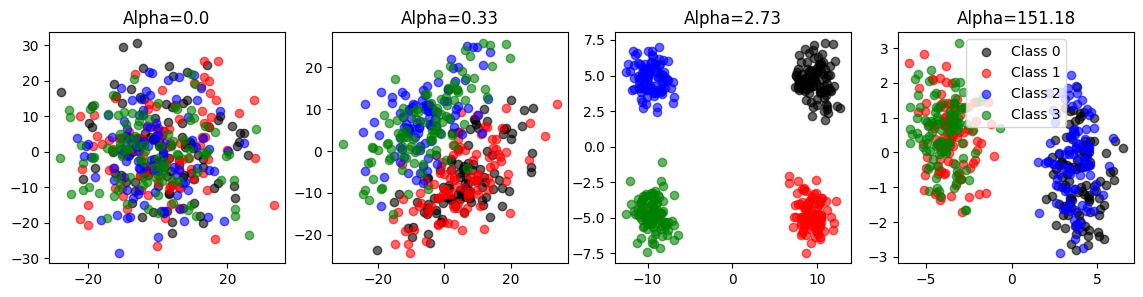

In [2]:
N = 400; D = 30; gap=3
# In B, all the data pts are from the same distribution, which has different variances in three subspaces.
B = np.zeros((N, D))
B[:,0:10] = np.random.normal(0,10,(N,10))
B[:,10:20] = np.random.normal(0,3,(N,10))
B[:,20:30] = np.random.normal(0,1,(N,10))


# In A there are four clusters.
A = np.zeros((N, D))
A[:,0:10] = np.random.normal(0,10,(N,10))
# group 1
A[0:100, 10:20] = np.random.normal(0,1,(100,10))
A[0:100, 20:30] = np.random.normal(0,1,(100,10))
# group 2
A[100:200, 10:20] = np.random.normal(0,1,(100,10))
A[100:200, 20:30] = np.random.normal(gap,1,(100,10))
# group 3
A[200:300, 10:20] = np.random.normal(2*gap,1,(100,10))
A[200:300, 20:30] = np.random.normal(0,1,(100,10))
# group 4
A[300:400, 10:20] = np.random.normal(2*gap,1,(100,10))
A[300:400, 20:30] = np.random.normal(gap,1,(100,10))
A_labels = [0]*100+[1]*100+[2]*100+[3]*100

cpca = CPCA(standardize=False)
cpca.fit_transform(A, B, plot=True, active_labels=A_labels)

## cPCA

In [4]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
n_runs = len(meta)
n_wins = 464
dfc_train_propofol = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_test_propofol = dfc[(meta["monkey"] == "jade") & meta["condition"].isin(['deep-propofol','light-propofol'])].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))
dfc_train_background = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
dfc_test_background = dfc[(meta["monkey"] == "jade")].reshape((-1, n_wins, 82, 82))
conditions_train = meta["condition"][meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
conditions_test = meta["condition"][meta["monkey"].isin(['jade']) & meta["condition"].isin(['deep-propofol','light-propofol'])]
dict_conditions = {"light-propofol":0, "deep-propofol":1}
labels_train = [dict_conditions[elem] for elem in conditions_train]
labels_test = [dict_conditions[elem] for elem in conditions_test]

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/dfc.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.15-add_compor-False/meta.csv")
iu = np.triu_indices(82,k=1)
dfc_flat = dfc[:,:,iu[0],iu[1]]
id_sessions_awake = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "awake"]
id_sessions_light_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "light-propofol"]
id_sessions_deep_propofol = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "deep-propofol"]
id_sessions_light_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane2"]
id_sessions_deep_sevoflurane = [i for i in range(len(meta)) if meta["condition"].iloc[i] == "sevoflurane4"]

In [10]:
id_sessions_sevoflurane = np.concatenate([id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane])
id_sessions_awake_sevoflurane = np.concatenate([id_sessions_awake,id_sessions_light_sevoflurane,id_sessions_deep_sevoflurane])
X = dfc_flat[id_sessions_sevoflurane,:,:].reshape(-1,3321)
Y = dfc_flat[id_sessions_awake_sevoflurane,:,:].reshape(-1,3321)
labels = [[0]*len(id_sessions_light_sevoflurane)*461 + [1]*len(id_sessions_deep_sevoflurane)*461]

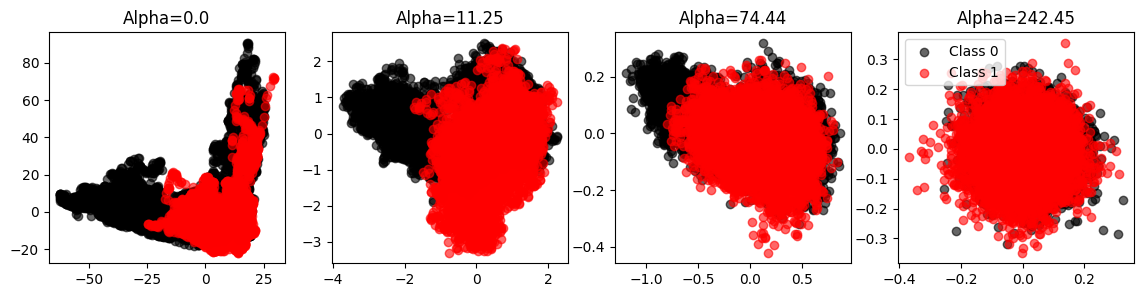

In [11]:
mdl = contrastive.CPCA()
projected_data = mdl.fit_transform(X,Y,plot = True,active_labels=labels)

In [14]:
projected_data_test = mdl.transform(X_test,plot = True,alpha_value = 2.15,active_labels=labels_test)

ValueError: shapes (4640,3321) and (1000,2) not aligned: 3321 (dim 1) != 1000 (dim 0)